We did provide the file ``` requirements.txt ``` though. 

In [1]:
#imports
import data
import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
import score_submission
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from threading import Thread
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

### Data Pre Processing

As described above, the train and test features contain a lot of missing values. Therefore, we need to develop a
strategy to deal with these missing values. In a nutshell, we are imputing with the median value for each feature
and standardizing each feature to zero mean and unit variance. This is happening in a number of steps

1. ```preprocessing.prepare_features()``` Fills up values for each for each patient based on their data. This means
that if patient ```i```has a missing feature at a certain timestamp, it will be filled up with the median from the other
timestamps. Important: If a patient is missing a value for a feature fora all timestamps, those values are left as
 missing and will be filled up in a next step. Finally, each patient is flattened into a single row vector.

2. ```preprocessing.impute_features()``` Looks at the flattened vectors of patients in the train and test dataset. Here,
missing values are again imputed based on the median, so if patient ```i```was missing values for blood pressure at all
timestamps, then those are filled up here with the median blood pressure of all patients for each timestamp ```j```.
After calling this method, the train and test features will not contain any ```np.nan```anymore.

3. ```preprocessing.standardize_features()``` standardizes the features to unit variance and zero mean over train and
test data.


In [2]:

raw_train_features = data.get_training_features()
raw_train_labels = data.get_training_labels()

reshaped_train_features = preprocessing.prepare_features(raw_train_features, read_from_file=False)

# make a split
s_train_features, s_test_features, s_train_labels, s_test_labels = train_test_split(
    reshaped_train_features, raw_train_labels,  test_size = 0.33)


# fill out values that were not imputed in last step becasue a patient was missing all of them
train, test = preprocessing.impute_features(s_train_features,s_test_features)

train_features, test_features = preprocessing.standardize_features(train, test)
train_labels = s_train_labels
test_labels = s_test_labels


In [3]:

classification_labels = ['LABEL_BaseExcess','LABEL_Fibrinogen','LABEL_AST','LABEL_Alkalinephos',
 'LABEL_Bilirubin_total','LABEL_Lactate','LABEL_TroponinI','LABEL_SaO2',
 'LABEL_Bilirubin_direct','LABEL_EtCO2','LABEL_Sepsis']


classification_params = {'loss': 'deviance', 'random_state': 0}

classification_models = {label : GradientBoostingClassifier(**classification_params) for label in classification_labels}

In [4]:
regression_labels = ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']

def cv_scoring_method(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y,y_pred)

cv_splitter = KFold(n_splits=5, random_state=0, shuffle=True)

regression_parameters = {'fit_intercept':True, 'scoring':cv_scoring_method, 'cv': cv_splitter}

regression_models = {key:RidgeCV(**regression_parameters) for key in regression_labels}

In [5]:
models = {**regression_models, **classification_models}

threads = list()

for label, model in models.items():
    thread = Thread(target=model.fit, args=[train_features,train_labels[label]])
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

In [6]:
result = pd.DataFrame(index=test_features.index, columns=[*classification_labels,*regression_labels])

for label in classification_labels:
    result[label] =  models[label].predict_proba(test_features)[:,1]

for label in regression_labels:
    result[label] = models[label].predict(test_features)


score_submission.get_score(test_labels,result)


 ### TASK 1 SCORES
LABEL_BaseExcess	 0.9182914130035211
LABEL_Fibrinogen	 0.7852176608005894
LABEL_AST	 0.7433631827185112
LABEL_Alkalinephos	 0.7459720477969645
LABEL_Bilirubin_total	 0.7466253069295605
LABEL_Lactate	 0.8059869423387888
LABEL_TroponinI	 0.8853798613761433
LABEL_SaO2	 0.8256507301392366
LABEL_Bilirubin_direct	 0.7284781969262446
LABEL_EtCO2	 0.9221532514555324

 ### TASK 2 SCORES
LABEL_Sepsis	 0.6883717742726169

 ### TASK 3 SCORES
LABEL_RRate	 0.6664143608015052
LABEL_ABPm	 0.8069155754454587
LABEL_SpO2	 0.6344661242433223
LABEL_Heartrate	 0.8112853821917285

 ### OVERALL SCORES: 
0.8107118593485092 0.6883717742726169 0.7297703606705037


0.7429513314305431

In [7]:
from sklearn.metrics import roc_curve
curves = {label: roc_curve(test_labels[label],result[label]) for label in classification_labels}

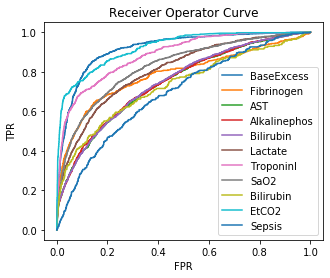

In [8]:

fig,ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(4)

for label, curve in curves.items():
    fpr, tpr, threshold = curve
    name = label.split('_')
    ax.plot(fpr,tpr, label=name[1])
ax.legend()
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Receiver Operator Curve')
fig.savefig('plot.png', dpi=300)

In [9]:
test_labels.set_index('pid', inplace=True)

In [86]:
print(test_labels.shape)
deltas = pd.DataFrame(index=test_labels.index, columns = regression_labels)

for label in regression_labels:
    delta =  result.loc[:,label].subtract(test_labels.loc[:,label])
    delta = delta.divide(test_labels[label])
    deltas[label] = delta
#    deltas.assign(delta)


(6269, 15)


start


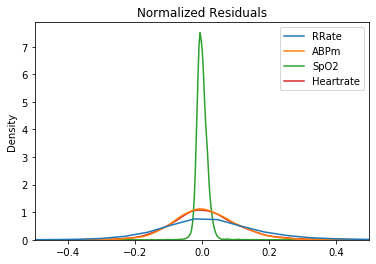

In [89]:
print('start')
ax = sb.kdeplot(data = deltas,  fill=False, legend = True)

ax.set_xlim((-0.5,0.5))
leg = ax.get_legend()
texts = leg.get_texts()
for index, text in enumerate(texts):
    text = text.get_text()
    split = text.split('_')
    texts[index].set_text(split[1])
ax.set_title('Normalized Residuals')
plt.savefig('hist.png', dpi=300)


In [88]:
plt.show()

In [85]:
del ax